Remi LeBlanc

Research Question / Hypothesis
----




My aim is to predict the burned area (area) of forest fires, in the northeast region of Portugal. Based on the the spatial, temporal, and weather variables where the fire is spotted.

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from   sklearn.impute             import *
from   sklearn.pipeline           import Pipeline
from   sklearn.preprocessing      import *
from   sklearn.tree               import DecisionTreeRegressor, ExtraTreeRegressor
from   sklearn.model_selection    import train_test_split, RandomizedSearchCV
from   sklearn.linear_model       import LinearRegression
from   sklearn.metrics            import mean_squared_error
from   sklearn.ensemble           import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from   sklearn.inspection         import permutation_importance
from   sklearn.compose            import ColumnTransformer

Load Data
-----

In [82]:
fires = pd.read_csv('forestFires.csv') #https://www.openml.org/d/42363

(array([508.,   6.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([   0.   ,  109.084,  218.168,  327.252,  436.336,  545.42 ,
         654.504,  763.588,  872.672,  981.756, 1090.84 ]),
 <a list of 10 Patch objects>)

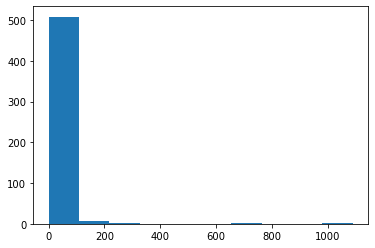

In [83]:
plt.hist(fires['area'])

The data is clearly has some outliers. However, is this case these outliers are very important to attempt to predict (big fire)

In [84]:
fires.isna().sum() # There are no NA values in the data

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

# Base Line

Compute a baseline with a simple Linear Regressor.

In [85]:
y = fires['area']
fires['RH'] = fires['RH'].astype(float)
X = fires.drop(['area'], axis = 1)

int_to_cat_cols = (X.dtypes == int)
cat_cols = (X.dtypes == object)
num_cols = (X.dtypes == float)

cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

preprocessing = ColumnTransformer([
    ('categorical', cat_pipe, cat_cols),
    ('categorical2', cat_pipe, int_to_cat_cols),
    ('continuous', num_pipe, num_cols)
])
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [86]:
pipe = Pipeline([
    ('preprocesssing', preprocessing),
    ('model', LinearRegression())
])

pipe.fit(X_train.values, y_train.values)

y_pred = pipe.predict(X_test.values)

(array([ 2.,  1.,  6., 16., 27., 19., 26., 22.,  8.,  3.]),
 array([-41.50146685, -31.65287387, -21.80428089, -11.95568791,
         -2.10709493,   7.74149805,  17.59009103,  27.43868401,
         37.28727699,  47.13586997,  56.98446295]),
 <a list of 10 Patch objects>)

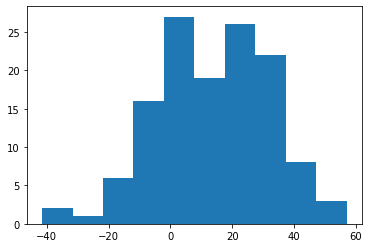

In [87]:
plt.hist(y_pred)

In [88]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
rmse, mse

(31.842144585294985, 1013.9221717908307)

Metrics scores aren't too bad, but we are predicting negative fire areas. That doesn't make any sense!

# Resample

Because the large fires are what we are intersted in, but there are so few of them, I will upsample the large fires and down sample the no fires. 

In [89]:
# Target engineering

fires['fire'] = fires['area'] > 0
fires['fire'] = fires['fire'].astype(int)
fires['large'] = fires['area'] >np.std(fires['area'])  # I determined large fires to be larger than one standard deviation 
fires['large'] = fires['large'].astype(int)


In [90]:
from sklearn.utils import resample
# upsample the large fires

df_majority = fires[(fires.large==0) & (fires.fire==1)]
df_minority = fires[fires.large==1]

df_minority_upsampled = resample(df_minority, 
                           replace=True,                     # sample with replacement
                           n_samples=100,                    # make 100 large fires (19 before)
                           random_state=123)                 # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [91]:
# downsample majority class - no fires
df_majority = fires[fires.fire==0]
df_minority = fires[fires.fire==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,         # sample without replacement
                                 n_samples=100,         # make no fires same amount as large fires
                                 random_state=123)      # reproducible results
 
# Combine minority class with downsampled majority class


In [92]:
df_resampled = pd.concat([df_majority_downsampled, df_upsampled])

In [93]:
df_resampled['large'].sum(), len(df_resampled)-df_resampled['fire'].sum()

(100, 100)

There are now equal amount of large fires and no fires

In [94]:
X = df_resampled.drop(['area', 'fire', 'large'], axis =1)
y = df_resampled['area']
int_to_cat_cols = (X.dtypes == int)
cat_cols = (X.dtypes == object)
num_cols = (X.dtypes == float)

Fit scikit-learn model
----

Because we do no want negative values, a linear model is not appropraite. A tree based approach will correctly deal with this. 
Using a tree approach does not require standardizing the numeric variables.

In [95]:
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessing = ColumnTransformer([
    ('categorical', cat_pipe, cat_cols),
    ('categorical2', cat_pipe, int_to_cat_cols)
])

In [96]:
# spilt into train, validation, and test

y = df_resampled['area']
X = df_resampled.drop(['area','fire','large'], axis =1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)


In [97]:
len(y_test), len(y_train), len(y_valid)

(85, 253, 113)

In [98]:
algorithms = [DecisionTreeRegressor(),
              AdaBoostRegressor(),
              ExtraTreeRegressor(), 
              RandomForestRegressor(),
              GradientBoostingRegressor()]

for algo in algorithms:
    pipe = Pipeline([('preprocessing', preprocessing), 
                     ('model',         algo)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{algo.__class__.__name__:<25} - mean squared error: {mse}")
    print(f"{algo.__class__.__name__:<25} - root mean squared error: {rmse}")
    print()

DecisionTreeRegressor     - mean squared error: 13236.577484477777
DecisionTreeRegressor     - root mean squared error: 115.05032587732109

AdaBoostRegressor         - mean squared error: 12080.471898809335
AdaBoostRegressor         - root mean squared error: 109.9112000608188

ExtraTreeRegressor        - mean squared error: 13299.838019020259
ExtraTreeRegressor        - root mean squared error: 115.32492366795765

RandomForestRegressor     - mean squared error: 11609.79463875339
RandomForestRegressor     - root mean squared error: 107.74875701720828

GradientBoostingRegressor - mean squared error: 12987.410590560534
GradientBoostingRegressor - root mean squared error: 113.96232092477116



RMSE penalizes outliers the most, and because we want to best predict the large fires we want to lowest RMSE score. 
The results are inconsistent so I will try a hyperparameter tune a few of these models to see which can best predict fire area.

# Ada Boost Regressor

In [99]:
hyperparameters = {
 'learning_rate': [0.1, 0.5, 1.0, 2.0],
 'loss': ['linear', 'square', 'exponential'],
 'n_estimators': [10, 50, 100, 1000]}

In [100]:
ada_cv = RandomizedSearchCV(estimator=AdaBoostRegressor(), 
                              param_distributions=hyperparameters, 
                              n_iter=10, 
                              cv=5, 
                              verbose=1,
                              random_state=43)

pipe_ada_cv = Pipeline([
        ('preprocessing', preprocessing), 
        ('lr', ada_cv)])

pipe_ada_cv.fit(X_train.values, y_train.values)
print()

Fitting 5 folds for each of 10 candidates, totalling 50 fits



In [101]:
hyperparams = ada_cv.best_estimator_.get_params()


In [102]:
pipe_ada = Pipeline([('preprocessing', preprocessing), 
                     ('model',     AdaBoostRegressor(**hyperparams))])

pipe_ada.fit(X_train, y_train)
y_pred = pipe_ada.predict(X_test)

In [103]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [104]:
r2 = pipe_ada.score(X_test.values, y_test.values)

In [105]:
scores_ada = {'rmse':rmse, 'r2':r2 }

# Gradient Boosting Regressor

In [106]:
hyperparameters = {
 'alpha': [0.1, 0.5, 0.9],
 'criterion': ['friedman_mse', 'mse'],
 'learning_rate': [0.01,0.1, 0.5, 1],
 'loss': ['ls', 'lad', 'huber', 'quantile'],
 'max_depth': [3, 5, 10],
 'max_features': [None, 5, 10],
 'min_samples_leaf': [1, 2, 5, 10],
 'n_estimators': [10, 50, 100, 1000],
 'warm_start': [False, True]}

In [107]:
gb_cv = RandomizedSearchCV(estimator=GradientBoostingRegressor(), 
                              param_distributions=hyperparameters, 
                              n_iter=10, 
                              cv=5, 
                              verbose=1,
                              random_state=43)

pipe_gb_cv = Pipeline([
        ('preprocessing', preprocessing), 
        ('model', gb_cv)])

pipe_gb_cv.fit(X_train.values, y_train.values)
print()

Fitting 5 folds for each of 10 candidates, totalling 50 fits



In [108]:
hyperparams = gb_cv.best_estimator_.get_params()


In [109]:
pipe_gb = Pipeline([
    ('preprocessing', preprocessing),
    ('m', GradientBoostingRegressor(**hyperparams))
])
pipe_gb.fit(X_train.values, y_train.values)
print()

In [110]:
y_pred = pipe_gb.predict(X_test.values)

In [111]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [112]:
r2 = pipe_gb.score(X_test.values, y_test.values)

In [113]:
scores_gb = {'rmse':rmse, 'r2':r2}

# Decision Tree Regressor

In [114]:
hyperparameters = {'ccp_alpha': [0.0, 0.1, 0.5],
 'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
 'max_depth': [None, 5, 10, 50, 100],
 'max_features': [None, 5, 10],
 'max_leaf_nodes': [None, 10, 50, 100, 1000],
 'min_samples_leaf': [1, 2, 5, 10],
 'splitter': ['best', 'random']}

In [115]:
dt_cv = RandomizedSearchCV(estimator=DecisionTreeRegressor(), 
                              param_distributions=hyperparameters, 
                              n_iter=10, 
                              cv=5, 
                              verbose=1,
                              random_state=43)

pipe_dt_cv = Pipeline([
        ('preprocessing', preprocessing), 
        ('lr', dt_cv)])

pipe_dt_cv.fit(X_train.values, y_train.values)
print()

Fitting 5 folds for each of 10 candidates, totalling 50 fits



In [116]:
hyperparams = dt_cv.best_estimator_.get_params()
hyperparams['random_state'] = 1

In [117]:
pipe_dt = Pipeline([
    ('preprocessing', preprocessing),
    ('m', DecisionTreeRegressor(**hyperparams))
])
pipe_dt.fit(X_train.values, y_train.values)
print()

In [118]:
y_pred = pipe_dt.predict(X_test.values)

In [119]:
r2 = pipe_dt.score(X_test.values, y_test.values)

In [120]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [121]:
scores_dt = {'rmse':rmse, 'r2':r2}

# Random Forest Regressor

In [122]:
hyperparameters = {
     'bootstrap': [True, False],
     'criterion': ['mse', 'mae'],
     'max_depth': [1, 10, 50, 100],
     'max_features': ['auto', 'sqrt', 'log2'],
     'max_leaf_nodes': [10, 100, 1000],
     'max_samples': [None],
     'min_samples_leaf': [1, 10, 20],
     'n_estimators': [10, 100, 1000],
     'oob_score': [False],
     'warm_start': [False, True]}

In [123]:
rfr_cv = RandomizedSearchCV(estimator=RandomForestRegressor(), 
                              param_distributions=hyperparameters, 
                              n_iter=10, 
                              cv=5, 
                              verbose=1, 
                              random_state=43)

pipe_rf_cv = Pipeline([('preprocessing',preprocessing),
                ('rf', rfr_cv)])

pipe_rf_cv.fit(X_train, y_train)
print()

Fitting 5 folds for each of 10 candidates, totalling 50 fits



In [124]:
hyperparams = rfr_cv.best_estimator_.get_params()


In [125]:
pipe_rf = Pipeline([
    ('preprocessing', preprocessing),
    ('m', RandomForestRegressor(**hyperparams))
])


In [126]:
pipe_rf.fit(X_train.values, y_train.values)
print()

In [127]:
y_pred = pipe_rf.predict(X_test.values)

In [128]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [129]:
r2 = pipe_rf.score(X_test.values, y_test.values)

In [130]:
scores_rf = {'rmse':rmse, 'r2':r2}

# Final Model

In [131]:
scores_ada, scores_gb, scores_rf, scores_dt

({'rmse': 141.25877644600448, 'r2': 0.06873977112851537},
 {'rmse': 116.2924354245241, 'r2': 0.3688347104970652},
 {'rmse': 110.36489805343362, 'r2': 0.4315371231152826},
 {'rmse': 115.4469326875538, 'r2': 0.3779791062215353})

In [132]:
scores_ada['model']='Ada Boost Regressor'
scores_gb['model']='Gradient Boosting'
scores_rf['model']='Random Forest'
scores_dt['model']='Decision Tree'

In [133]:
models = pd.DataFrame.from_dict([scores_ada, scores_gb, scores_rf, scores_dt])

In [134]:
models

,rmse,r2,model
0,141.258776,0.068740,Ada Boost Regressor
1,116.292435,0.368835,Gradient Boosting
2,110.364898,0.431537,Random Forest
3,115.446933,0.377979,Decision Tree


In [ ]:
plt.plot(models.model, models.rmse)
plt.title('RMSE')

## Random forest has the lowest RMSE and the highest R^2

I decided to go with the Random Forest Regressor because of the metrics, and I would also expect to do well predicting this kind of data. With these outliers it is easy to overfit or not capture then accurately but a RF does a good job at this

In [136]:
y_pred = pipe_rf.predict(X_valid.values)

In [137]:
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
r2 = pipe_rf.score(X_valid.values, y_valid.values)
rmse, r2

(111.72220177386555, 0.29918763820436267)

In [ ]:
r = permutation_importance(pipe_rf, X_test.values, y_test.values,
                            n_repeats=30,
                            random_state=0)

importances = list(zip(X_train.columns, r.importances_mean))
importances = sorted(importances, key=lambda x: x[1])

plt.barh(*zip(*importances))
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Permutation Feature Importance')
plt.show()

Features importance is a very big take away from this model. This tells us which of the features was most predictive of a fire. As shown above, the day of the week, the month, and location are the bigget indicators of a fire. 

In [ ]:
plt.hist(y_valid)
plt.hist(y_pred)

plt.xlabel('Burn area (hectares)')
plt.ylabel('Number of fires')
plt.title('Predicted Area')

### Test model of original, not upsampled data set

In [ ]:
y = fires['area']

In [ ]:
X = fires.drop(['area', 'fire', 'large'], axis = 1)

In [ ]:
y_pred = pipe_rf.predict(X.values)

In [ ]:
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae, rmse

In [ ]:
plt.hist(fires['area'])
plt.hist(y_pred)
plt.xlabel('Burn area (hectares)')
plt.ylabel('Number of fires')
plt.title('Original Sample Data (orange = predicted)')

I was suspicous the model only worked well on the upsampled data. So I tried to predict the original data set and found it did a very good job at predicting burned area, including the large fires

Upsampling turned out to be very effective method to help predict the large fires. 

There are obvious reason why this model is important. Uncontrolled forest fires can cause a lot of damage and because of human caused climate change, forest fires have become more frequent and larger (this only references my own personal knowledge, especially being in California in 2020). The features importances of this model can tell us a lot about what indicators might point to a fire the most. Out best model, the random forest, indicate that day, month, and location are the biggest predictors. A continuation of this project would be to find out which month and days, and which locations are the most predictive. Knowing these could help fire fighter be more prepared, and give warning to recreational users of the park to be extra safe when dealing with fire.